In [69]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import itertools
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
sns.set_theme(style="whitegrid")

In [70]:
cu_path = os.getcwd()
file = cu_path + "/spam.csv"
df = pd.read_csv(file, encoding="latin-1")
df = df[["v1" , "v2"]]
df.columns = ["label" , "context"]

In [71]:
display(df)

,label,context
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


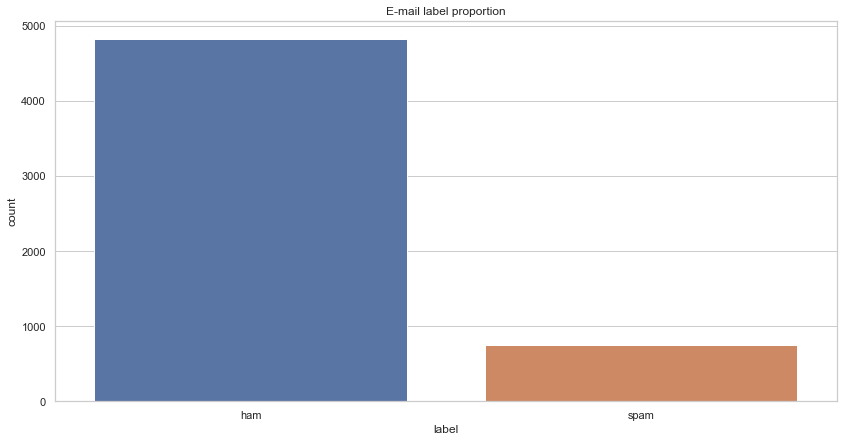

In [72]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.countplot(x=df["label"]).set(title='E-mail label proportion')
plt.show()

Since the class is Imbalance, I performed stratified sampling when splitting the data into training and test. Moreover, when building the ML model, I set the class_weight as "balanced".

### **Preprocess**

#### **Delete the unnecessary word**

In [73]:
def delete_unnecessary(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text
df['context_clean'] = df['context'].apply(delete_unnecessary)

In [74]:
display(df)

,label,context,context_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the time we have tried contact u u h...
5568,ham,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity was in mood for that soany other suggest...
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like id ...


#### **Stemming**

In [75]:
stemmer = nltk.SnowballStemmer("english")
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
df['context_clean'] = df['context_clean'].apply(stemm_text)

#### **Removing stopwords**

In [76]:
stop_words = stopwords.words('english')
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
df['context_clean'] = df['context_clean'].apply(remove_stopwords)

In [77]:
display(df)

,label,context,context_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail onli bugi n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,time tri contact u u å£ pound prize claim e...
5568,ham,Will Ì_ b going to esplanade fr home?,ì b go esplanad fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",piti mood soani suggest
5570,ham,The guy did some bitching but I acted like i'd...,guy bitch act like id interest buy someth els ...


#### **Label encoding for dependent variable**

In [78]:
df["label"] = df["label"].replace({"ham" : 0 , "spam" : 1})

In [79]:
display(df)

,label,context,context_clean
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail onli bugi n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,time tri contact u u å£ pound prize claim e...
5568,0,Will Ì_ b going to esplanade fr home?,ì b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",piti mood soani suggest
5570,0,The guy did some bitching but I acted like i'd...,guy bitch act like id interest buy someth els ...


#### **Word cloud**

##### **No-Spam emails**

In [80]:
def make_list(text):
  each_list = text.split()
  return each_list

C:\Users\yuto1\AppData\Local\Temp/ipykernel_30036/3616107993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_false["vis_text"] = df_false["context_clean"].apply(make_list)


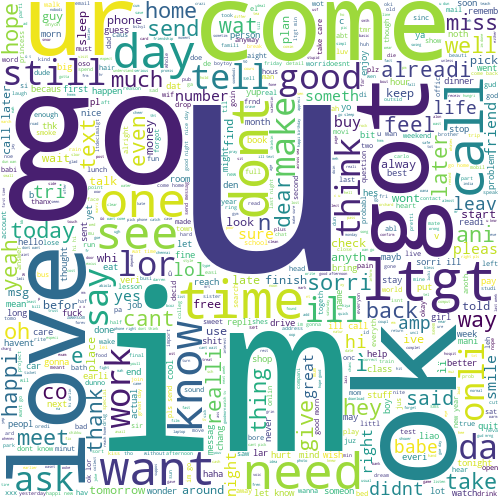

In [81]:
df_false = df[df["label"] == 0]
df_false["vis_text"] = df_false["context_clean"].apply(make_list)
false_list = list(itertools.chain.from_iterable(df_false["vis_text"].tolist()))
false_string = ','.join(false_list)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',width=500, height=500)
wordcloud.generate(false_string)
wordcloud.to_image()

##### **Spam emails**

C:\Users\yuto1\AppData\Local\Temp/ipykernel_30036/9068666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true["vis_text"] = df_true["context_clean"].apply(make_list)


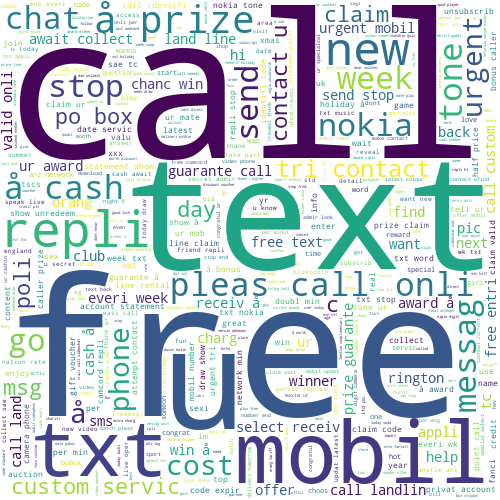

In [82]:
df_true = df[df["label"] == 1]
df_true["vis_text"] = df_true["context_clean"].apply(make_list)
true_list = list(itertools.chain.from_iterable(df_true["vis_text"].tolist()))
true_string = ','.join(true_list)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',width=500, height=500)
wordcloud.generate(true_string)
wordcloud.to_image()

#### **Split the data into train and test data**

In [83]:
df = df[["label" , "context_clean"]]
X_train, X_test, Y_train, Y_test = train_test_split(df["context_clean"], df["label"], test_size=0.3, random_state=100,
                                                    stratify=df["label"])

#### **Vectorization using TF-IDF**

In [84]:
def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [85]:
tfidf_vect = TfidfVectorizer()
tfidf_vect_fit=tfidf_vect.fit(X_train)
X_train=vectorize(X_train,tfidf_vect_fit)
X_test=vectorize(X_test,tfidf_vect_fit)

C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### **Model**

#### **Optimize the parameters with grid search**

In [86]:
param_grid = {
    'n_estimators': [i for i in range(1,500,100)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(1,30,10)],
    'min_samples_leaf': [i for i in range(1,5,2)],
    'min_samples_split': [i for i in range(1,5,2)],
    'criterion' :['gini', 'entropy']
}
clf = RandomForestClassifier(random_state=100)
cv_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5 , scoring = "f1",n_jobs = -1)
cv_clf.fit(X_train, Y_train)

C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
900 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatc

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 11, 21],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [1, 3],
                         'n_estimators': [1, 101, 201, 301, 401]},
             scoring='f1')

#### **Build Random Forest Model**

In [87]:
clf = RandomForestClassifier(
  random_state=100,
  criterion = cv_clf.best_params_["criterion"],
  max_depth = cv_clf.best_params_["max_depth"],
  max_features = cv_clf.best_params_["max_features"],
  min_samples_leaf = cv_clf.best_params_["min_samples_leaf"],
  min_samples_split = cv_clf.best_params_["min_samples_split"],
  n_estimators = cv_clf.best_params_["n_estimators"],
  class_weight = "balanced"
  )
clf.fit(X_train, Y_train)
y_test_pred  = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

In [88]:
f1_score = f1_score(Y_test,y_test_pred)
recall_score = recall_score(Y_test,y_test_pred)
precision_score = precision_score(Y_test,y_test_pred)
print("F1 score : " , f1_score)
print("Recall score : " , recall_score)
print("Precision score : " , precision_score)

F1 score :  0.9047619047619048
Recall score :  0.8482142857142857
Precision score :  0.9693877551020408


C:\Users\yuto1\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


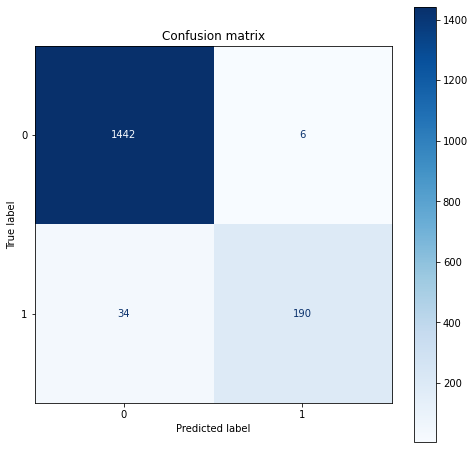

In [89]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(8, 8))
cmap = plt.get_cmap('Blues')
plot_confusion_matrix(clf, X_test, Y_test , cmap = cmap , ax=ax)
plt.title('Confusion matrix')
plt.show()

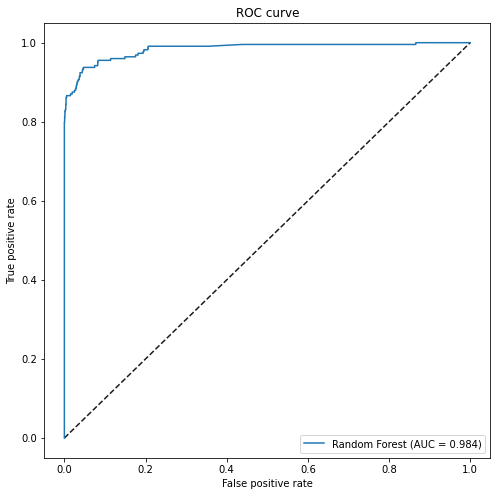

In [90]:
fpr_rf, tpr_rf, thresholds_lstm = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
rf_auc = roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1])

plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.3f})'.format(rf_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()